In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
import matplotlib
def brown_green():
    '''
    returns a colormap based on colorbrewer diverging brown->green
    '''

    # colorbrewer colormap, diverging, brown->green
    cmap = np.zeros([11,3]);
    cmap[0,:] = 84,48,5
    cmap[1,:] = 140,81,10
    cmap[2,:] = 191,129,45
    cmap[3,:] = 223,194,125
    cmap[4,:] = 246,232,195
    cmap[5,:] = 245,245,245
    cmap[6,:] = 199,234,229
    cmap[7,:] = 128,205,193
    cmap[8,:] = 53,151,143
    cmap[9,:] = 1,102,94
    cmap[10,:] = 0,60,48
    cmap = matplotlib.colors.ListedColormap(cmap/256)
    
    return cmap

In [3]:
import statsmodels.api as sm

In [4]:
from utils import *

In [5]:
from scipy import stats

In [27]:
cf=24*60*60*365

In [6]:
d='/glade/scratch/djk2120/postp/'
files=sorted(glob.glob(d+'*slope*.nc'))
ds=xr.open_mfdataset(files,combine='nested',concat_dim='mem')

In [7]:
y1,y2=str(ds.years[0].values).split('-')
yy=slice(y1,y2)

In [8]:
files=sorted(glob.glob(d+'*.ann.nc'))
def pp(ds):
    return ds[['TWS','NBP']].sel(year=yy)
g=xr.open_mfdataset(files,combine='nested',concat_dim='mem',preprocess=pp)
g['mem']=[f.split('/')[-1].split('ann')[0] for f in files]

In [9]:
la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea

In [10]:
whit=xr.open_dataset('whitfull.nc')

In [325]:
yy=slice(1976,1990)
twsa=1e-9*la.sum()*detrend_dim(gmean(g.TWS.sel(year=yy),la).isel(biome=0),'year')
nbpa=1e-9*la.sum()*cf*detrend_dim(gmean(g.NBP.sel(year=yy),la).isel(biome=0),'year')

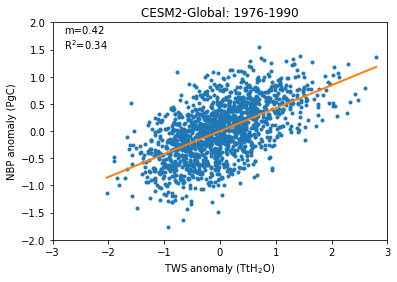

In [380]:
plt.plot(twsa.values.ravel(),nbpa.values.ravel(),'.')
m,b,r,p,err=stats.linregress(twsa.values.ravel(),nbpa.values.ravel())
resid=nbpa-m*twsa-b
x=np.array([twsa.min(),twsa.max()])
plt.plot(x,m*x+b,lw=2);
plt.xlim([-3,3])
plt.ylim([-2,2]);
plt.text(-2.8,1.8,'m='+str(np.round(m,2)))
plt.text(-2.8,1.5,r'R$^2$='+str(np.round(r**2,2)))
plt.title('CESM2-Global: '+y1+'-'+y2)
plt.xlabel(r'TWS anomaly (TtH$_2$O)');
plt.ylabel('NBP anomaly (PgC)');

In [68]:
lab=la.groupby(whit.biome).sum().compute()
twsb=detrend_dim(1e-9*lab*gmean(g.TWS,la,whit.biome),'year')
nbpb=detrend_dim(1e-9*cf*lab*gmean(g.NBP,la,whit.biome),'year')

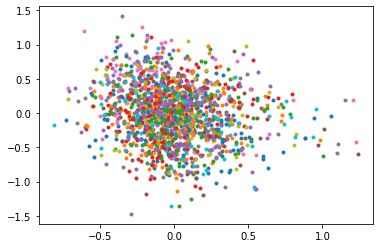

In [384]:
plt.plot(twsb.sel(biome=3),resid,'.');

In [398]:
#nbp-resid vs biome-level TWS OLS
x=twsb.stack({'my':['mem','year']}).T.values
y=resid.stack({'my':['mem','year']}).values
sm.OLS(y,x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.334
Model:                            OLS   Adj. R-squared (uncentered):              0.329
Method:                 Least Squares   F-statistic:                              74.65
Date:                Fri, 02 Jun 2023   Prob (F-statistic):                   6.35e-124
Time:                        17:17:40   Log-Likelihood:                         -565.68
No. Observations:                1500   AIC:                                      1151.
Df Residuals:                    1490   BIC:                                      1205.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1534      0.241     -0.637      0.524      -0.626       0.319
x2             0.7952      0.091      8.778      0.000       0.618       0.973
x3             0.2958      0.025     11.618      0.000       0.246       0.346
x4            -0.5707      0.038    -15.062      0.000      -0.645      -0.496
x5            -0.7182      0.837     -0.858      0.391      -2.360       0.923
x6            -0.4143      0.144     -2.868      0.004      -0.698      -0.131
x7            -0.4318      0.087     -4.959      0.000      -0.603      -0.261
x8            -0.7017      0.187     -3.742      0.000      -1.069      -0.334
x9            -0.7919      0.112     -7.083      0.000      -1.011      -0.573
x10           -1.4510      0.183     -7.910      0.000      -1.811      -1.091
==============================================================================
Omnibus:                        1.826   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.822
Skew:                           0.048   Prob(JB):                        0.402
Kurtosis:                       2.858   Cond. No.                         45.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

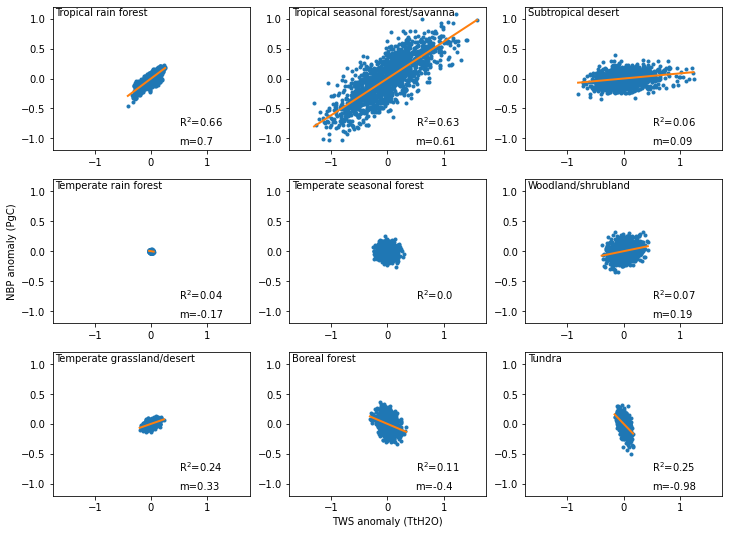

In [190]:
plt.figure(figsize=[12,9])
mvals={}
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.plot(twsb.sel(biome=i),nbpb.sel(biome=i),'C0.')
    plt.xlim([-1.75,1.75])
    plt.ylim([-1.2,1.2])
    plt.text(-1.7,1.05,whit.biome_name[i].values)
    

    
    m,b,r,p,err=stats.linregress(twsb.sel(biome=i).values.ravel(),nbpb.sel(biome=i).values.ravel())
    mvals[i]=m
    plt.text(0.5,-0.8,r'R$^2$='+str(np.round(r**2,2)))
    if p<0.05:
        plt.text(0.5,-1.1,'m='+str(np.round(m,2)))
        x=np.array([twsb.sel(biome=i).min(),twsb.sel(biome=i).max()])
        plt.plot(x,m*x+b,'C1',lw=2)
    
    if i==4:
        plt.ylabel('NBP anomaly (PgC)')
    if i==8:
        plt.xlabel('TWS anomaly (TtH2O)')

In [194]:
import itertools

In [232]:
y=nbpa.stack({'memyear':['mem','year']}).values
bests=[]
for nb in 1+np.arange(9):
    best=(0,0)
    for c in itertools.combinations(biomes,nb):
        x=twsb.sel(biome=c).stack({'memyear':['mem','year']}).T.values
        lm=sm.OLS(y,x).fit()
        r2=lm.rsquared
        if r2>best[0]:
            best=(r2,c)
    bests.append(best)

In [233]:
bests

[(0.4760354842221296, (2,)),
 (0.5400565541039906, (1, 2)),
 (0.5492732231239102, (1, 2, 9)),
 (0.5543416555653615, (1, 2, 3, 9)),
 (0.5573631597994477, (1, 2, 3, 8, 9)),
 (0.5582189088842184, (1, 2, 3, 7, 8, 9)),
 (0.5582520366459592, (1, 2, 3, 4, 7, 8, 9)),
 (0.5582604240805131, (1, 2, 3, 4, 6, 7, 8, 9)),
 (0.5582604240814519, (1, 2, 3, 4, 5, 6, 7, 8, 9))]

In [241]:
m,b,r,p,err=stats.linregress(twsa.values.ravel(),nbpa.values.ravel())
r2=[r**2]
for b in 1+np.arange(9):
    m,b,r,p,err=stats.linregress(twsb.sel(biome=b).values.ravel(),nbpa.values.ravel())
    r2.append(r**2)
    


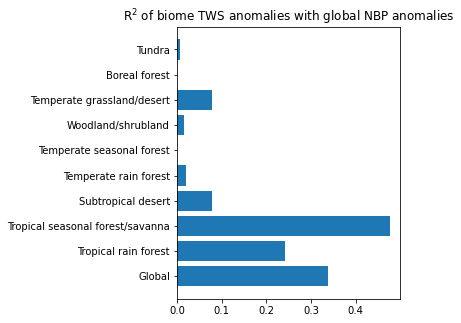

In [254]:
plt.figure(figsize=[4,5])
plt.barh(range(10),r2)
plt.yticks(range(10),['Global',*whit.biome_name[1+np.arange(9)].values]);
plt.title(r'R$^2$ of biome TWS anomalies with global NBP anomalies');

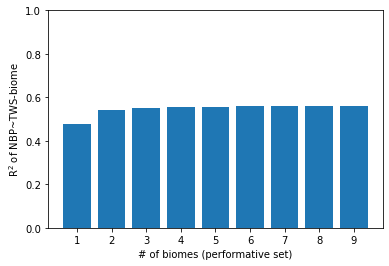

In [404]:
plt.bar(range(1,10),[b[0] for b in bests])
plt.ylim([0,1])
plt.xticks(range(1,10))
plt.xlabel('# of biomes (performative set)')
plt.ylabel(r'R$^2$ of NBP~TWS-biome');

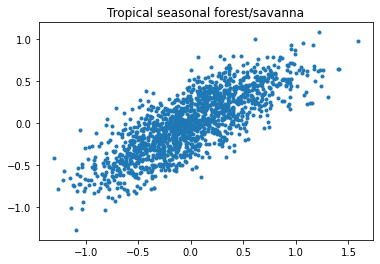

In [84]:
plt.plot(twsb.sel(biome=2),nbpb.sel(biome=2),'C0.');
plt.title(whit.biome_name.sel(biome_id=2).values);
m,b,r,p,err=stats.linregress(twsb.sel(biome=2).values.ravel(),nbpb.sel(biome=2).values.ravel())

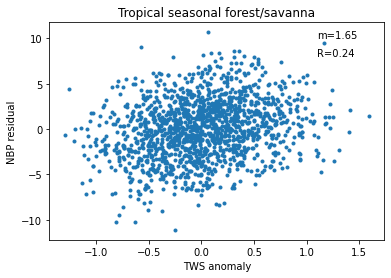

In [154]:
plt.plot(twsb.sel(biome=2),resids,'C0.');
plt.xlabel('TWS anomaly')
plt.ylabel('NBP residual')
plt.title(whit.biome_name.sel(biome_id=2).values);
m,b,r,p,err=stats.linregress(twsb.sel(biome=2).values.ravel(),resids.values.ravel())
plt.text(1.1,10,'m='+str(np.round(m,2)))
plt.text(1.1,8,'R='+str(np.round(r,2)));

In [156]:
x=twsb.sel(biome=[2,3]).stack({'memyear':['mem','year']}).T.values
y=resids.stack({'memyear':['mem','year']}).values
sm.OLS(y,x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.176
Model:                            OLS   Adj. R-squared (uncentered):              0.175
Method:                 Least Squares   F-statistic:                              159.7
Date:                Fri, 02 Jun 2023   Prob (F-statistic):                    1.40e-63
Time:                        11:33:25   Log-Likelihood:                         -3758.2
No. Observations:                1500   AIC:                                      7520.
Df Residuals:                    1498   BIC:                                      7531.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9735      0.185     16.031      0.000       2.610       3.337
x2            -4.5590      0.311    -14.673      0.000      -5.168      -3.950
==============================================================================
Omnibus:                        0.860   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.650   Jarque-Bera (JB):                0.913
Skew:                          -0.055   Prob(JB):                        0.633
Kurtosis:                       2.948   Cond. No.                         2.13
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
x=twsb.stack({'memyear':['mem','year']}).T.values
y=resids.stack({'memyear':['mem','year']}).values
sm.OLS(y,x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.334
Model:                            OLS   Adj. R-squared (uncentered):              0.329
Method:                 Least Squares   F-statistic:                              74.65
Date:                Fri, 02 Jun 2023   Prob (F-statistic):                   6.35e-124
Time:                        11:33:47   Log-Likelihood:                         -3598.5
No. Observations:                1500   AIC:                                      7217.
Df Residuals:                    1490   BIC:                                      7270.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1585      1.818     -0.637      0.524      -4.724       2.407
x2             6.0059      0.684      8.778      0.000       4.664       7.348
x3             2.2342      0.192     11.618      0.000       1.857       2.611
x4            -4.3103      0.286    -15.062      0.000      -4.872      -3.749
x5            -5.4239      6.321     -0.858      0.391     -17.822       6.974
x6            -3.1289      1.091     -2.868      0.004      -5.269      -0.989
x7            -3.2609      0.658     -4.959      0.000      -4.551      -1.971
x8            -5.2995      1.416     -3.742      0.000      -8.077      -2.522
x9            -5.9811      0.844     -7.083      0.000      -7.637      -4.325
x10          -10.9589      1.386     -7.910      0.000     -13.677      -8.241
==============================================================================
Omnibus:                        1.826   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.822
Skew:                           0.048   Prob(JB):                        0.402
Kurtosis:                       2.858   Cond. No.                         45.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [159]:
x=twsb.stack({'memyear':['mem','year']}).T.values
y=nbpa.stack({'memyear':['mem','year']}).values
sm.OLS(y,x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.559
Model:                            OLS   Adj. R-squared (uncentered):              0.556
Method:                 Least Squares   F-statistic:                              188.6
Date:                Fri, 02 Jun 2023   Prob (F-statistic):                   3.04e-256
Time:                        11:35:21   Log-Likelihood:                         -3598.5
No. Observations:                1500   AIC:                                      7217.
Df Residuals:                    1490   BIC:                                      7270.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0276      1.818      1.115      0.265      -1.538       5.593
x2             9.1919      0.684     13.434      0.000       7.850      10.534
x3             5.4203      0.192     28.187      0.000       5.043       5.797
x4            -1.1243      0.286     -3.929      0.000      -1.686      -0.563
x5            -2.2378      6.321     -0.354      0.723     -14.636      10.160
x6             0.0572      1.091      0.052      0.958      -2.083       2.197
x7            -0.0748      0.658     -0.114      0.909      -1.365       1.215
x8            -2.1134      1.416     -1.492      0.136      -4.891       0.664
x9            -2.7950      0.844     -3.310      0.001      -4.451      -1.139
x10           -7.7728      1.386     -5.610      0.000     -10.491      -5.055
==============================================================================
Omnibus:                        1.826   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.822
Skew:                           0.048   Prob(JB):                        0.402
Kurtosis:                       2.858   Cond. No.                         45.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

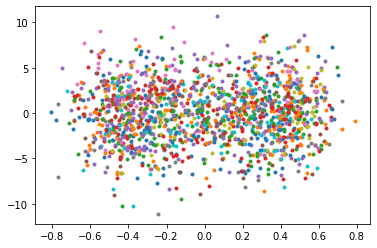

In [98]:
plt.plot(twsb.sel(biome=2)/abs(twsb).sum(dim='biome'),resids,'.');

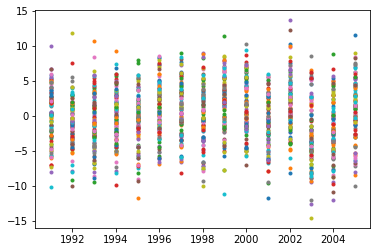

In [52]:
twsa=detrend_dim(tmp.TWS.sel(year=slice(1991,2005)),'year')
nbpa=cf*detrend_dim(tmp.NBP.sel(year=slice(1991,2005)),'year')
plt.plot(range(1991,2006),nbpa.T,'.');

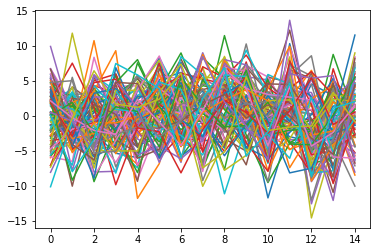

(array([ 7.,  7., 10., 27., 19., 11., 12.,  3.,  1.,  3.]),
 array([0.05520897, 0.133628  , 0.21204703, 0.29046606, 0.36888509,
        0.44730412, 0.52572315, 0.60414218, 0.68256121, 0.76098024,
        0.83939927]),
 <BarContainer object of 10 artists>)

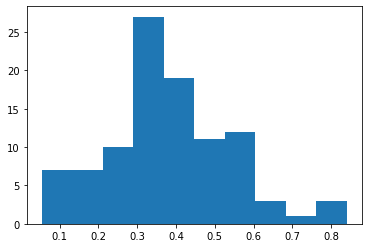

In [15]:
plt.hist(ds.glob.sel(lm='m'))

In [ ]:
twsvar=((ds.p<0.05)*la*detrend_dim(g.TWS,'year')).stack({'memyear':['mem','year']}).var(dim='memyear').compute()

In [ ]:
mgrids=(twsvar/twsvar.sum()*ds.slope.where(p<0.05)).sum(dim=['lat','lon']).compute()

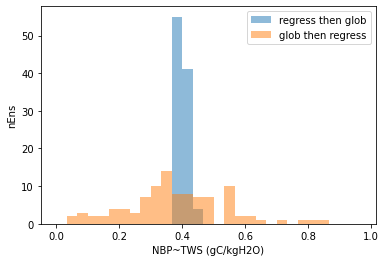

In [196]:
plt.hist(mgrids,np.arange(30)/30,alpha=0.5,label='regress then glob')
plt.hist(ds.glob[:,0],np.arange(30)/30,alpha=0.5,label='glob then regress')
plt.legend();
plt.xlabel('NBP~TWS (gC/kgH2O)')
plt.ylabel('nEns');

In [10]:
whit=xr.open_dataset('whitfull.nc')

In [11]:
sb=ds.slope.groupby(whit.biome).mean().compute()

In [14]:
twsvarbiome=(la*g.TWS).groupby(whit.biome).sum().var(dim=['mem','year']).compute()
twsvarbiome=100*twsvarbiome/twsvarbiome.sum()

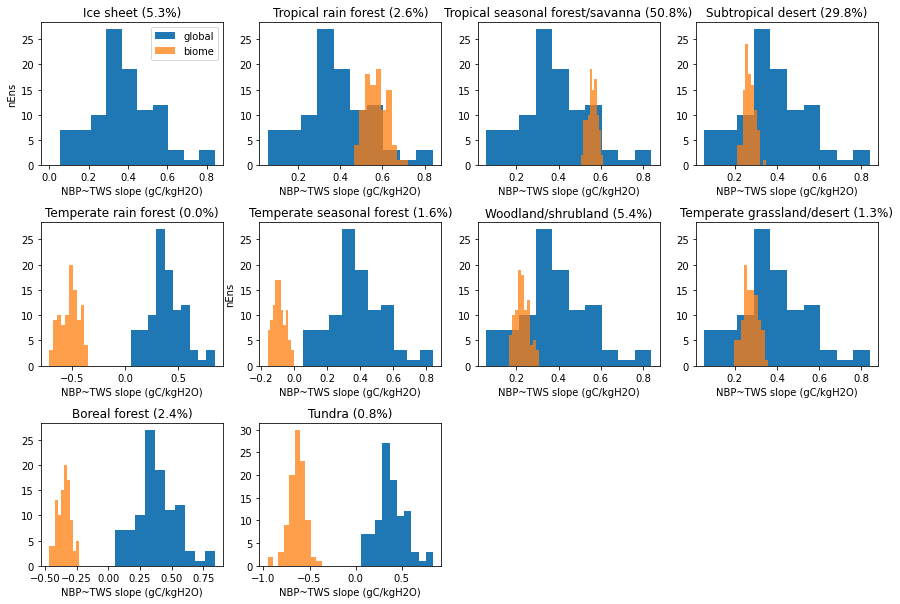

In [15]:
plt.figure(figsize=[15,10])
for i,b in enumerate(whit.biome_name.values):
    plt.subplot(3,4,i+1)
    plt.hist(ds.glob.isel(lm=0),label='global')
    plt.hist(sb.sel(biome=i),alpha=0.75,label='biome')
    plt.title(b+' ('+str(np.round(twsvarbiome.isel(biome=i).values,1))+'%)')

    plt.xlabel('NBP~TWS slope (gC/kgH2O)')
    if i%5==0:
        plt.ylabel('nEns')
    if i==0:
        plt.legend(loc=1)
    
plt.subplots_adjust(hspace=0.4)

In [16]:
twsvb=(la*g.TWS).groupby(whit.biome).sum().var(dim='year')

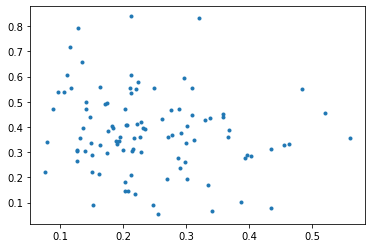

In [22]:
plt.plot((twsvb/twsvb.sum(dim='biome')).isel(biome=3),ds.glob.isel(lm=0),'.')

In [ ]:
5+5

In [104]:
pprob=np.zeros(la.shape)
for mem in ps:
    pprob=pprob+1/len(ps)*(ps[mem]<0.05)
    

In [113]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [153]:
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in np.linspace(0,255,8).astype(int)]
vd=matplotlib.colors.ListedColormap(cmaplist)

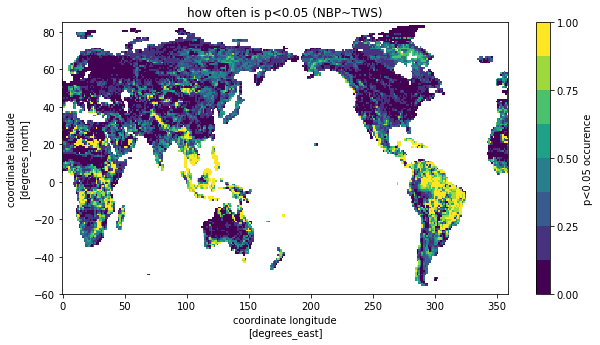

In [156]:
plt.figure(figsize=[10,5])
kwargs={'label':'p<0.05 occurence','ticks':np.arange(5)/4}
xr.DataArray(pprob,coords=la.coords).where(la>0).plot(cmap=vd,
                                                      cbar_kwargs=kwargs);
plt.ylim([-60,85])
plt.title('how often is p<0.05 (NBP~TWS)');

In [171]:
def pp(ds):
    return ds[['TSA','PREC']].sel(year=yy)
ds=xr.open_mfdataset(files,concat_dim='mem',combine='nested',
                     preprocess=pp).stack({'memyear':['mem','year']}).mean(dim='memyear').compute()

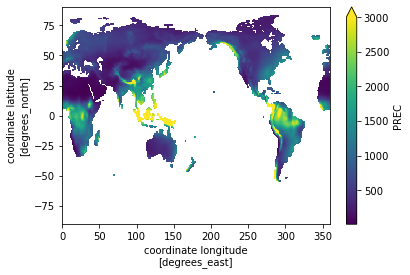

In [176]:
(24*60*60*365*ds.PREC).where(la>0).plot(vmax=3000)

In [178]:
savg=xr.DataArray([ss[m]/len(ss) for m in ss]

In [244]:
ix=(la>0)&(ds.NEP.mean(dim=['ens','year'])>0)

In [263]:
tsa=ds.TSA.mean(dim=['ens','year']).compute()
prec=ds.PREC.mean(dim=['ens','year']).compute()

In [282]:
tvals=265+np.arange(16)*2.5
pvals=100*np.arange(31)
s=np.zeros([30,15])+np.nan
for i in range(30):
    for j in range(15):
        ixt=(tsa>=tvals[j])&(tsa<tvals[j+1])
        ixp=(prec>=pvals[i])&(prec<pvals[i+1])
        ixtp=(ixt)&(ixp)
        if ix.values[ixtp].sum()>15:
            s[i,j]=np.nanmean(slopes[ixtp])

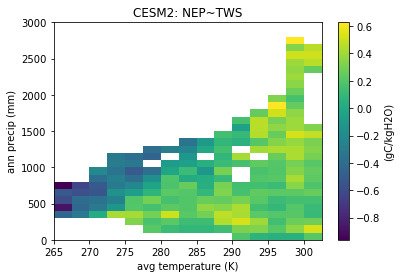

In [288]:
plt.pcolormesh(tvals,pvals,s)
plt.colorbar(label='(gC/kgH2O)')
plt.xlabel('avg temperature (K)')
plt.ylabel('ann precip (mm)')
plt.title('CESM2: NEP~TWS');